EXES: Telluric Correction
================
* **Aim**: Retreive an atmospheric model from the Planetary Spectrum Generator ([PSG](https://psg.gsfc.nasa.gov/)) and use it to remove telluric features. <br />
* **Data**: Level 3 grism data of the Sirius. <br />
* **Tools**: astropy, scipy, PSG <br />
* **Instrument**: EXES <br />
* **Documentation**: [EXES data handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/EXES_GO-DataHandbook.pdf)
* **Notebook repository**: https://github.com/SOFIAObservatory/Recipes

Goals
-------
* Inspect EXES data structure.
* Plot EXES spectrum.
* Retrieve atmospheric model from PSG.
* Guassian broadening of model.
* Telluric correction.

Introduction
----------

All EXES level 3 data come with an atmospheric example model or ATRAN model provided for an estimate of the effects of the atmosphere. To do a better job of this, we can retrieve atmospheric models from the PSG and tune different parameters to get something closer to what is found within the target spectrum. 

Ingredients
-----------

Level 3 EXES data of the star Arcturus. An internet connection. 

**The data can be directly downloaded [here]()** (to be added soon)

Imports
-----------

In [1]:
import os
import time
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.units as u
import numpy as np
from scipy.interpolate import interp1d
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve

%matplotlib inline

In [2]:
# read fits files
hdu = fits.open("../example_data/EXES/F0749_EX_SPE_7500601_EXEELONEXEECHL_MRD_0018.fits")

In [3]:
# print first 15 lines of header
hdu[0].header[0:10]

SIMPLE  =                    T / Written by IDL:  Tue Jul 13 14:54:17 2021      
BITPIX  =                  -64 /Real*8 (double precision)                       
NAXIS   =                    2 /                                                
NAXIS1  =                27044 /                                                
NAXIS2  =                    4 /                                                
ADDTIME =              456.741 / Effective on-source time                       
AIRSPEED=              484.188 / knots, aircraft airspeed das.ic1080...         
ALTI_END=              40997.0 / feet, aircraft altitude end fms.altitude)      
ALTI_STA=              40998.0 / feet, aircraft altitude start das.ic1080_1     
AOR_ID  = '75_0060_1'          / Astronomical Observation Request Identifie     

In [4]:
# specify column data
wavenumber = hdu[0].data[0]
flux_unit = u.erg * u.s ** (-1) * (u.cm) ** -2 * u.sr ** (-1)
flux = hdu[0].data[1] * flux_unit
flux = flux/np.max(flux)
uncertainty = hdu[0].data[2] * flux_unit
atran = hdu[0].data[3]

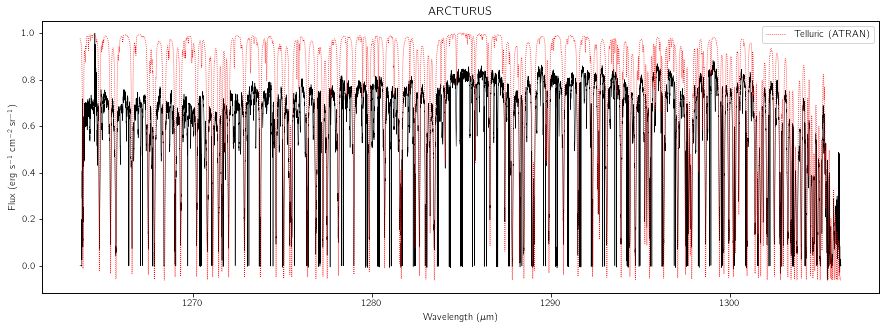

In [5]:
# Plot the whole spectrum
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx() # plotting both but on different axes
ax2.set_yticks([]) #remove ax2 ticks
ax1.plot(wavenumber, flux, lw=0.5, c="k")
ax2.plot(wavenumber, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)")
ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)")
ax1.set_xlabel(r"Wavelength ($\mu$m)")
plt.legend()
plt.title("ARCTURUS")
plt.show()

While the average atmospheric (ATRAN) model throughout the night does a good job at estimating the impact of the atmosphere on these observations, we need to do a better job to subtract out these features.  

We will use [Planetary Spectrum Generator (PSG)](https://psg.gsfc.nasa.gov/) API to retreive a more-appropriate model. 

Edit PSG config file
---------------

The PSG model is selected based on parameters specified in a config.txt file. We have provided an example of a config.txt file but can make changes to that file within this notebook. 

In [6]:
# read config file
with open('../example_data/EXES/psg_cfg_dewitt.txt') as f:
    config = f.readlines()

In [7]:
# print first lines of config.txt file
config[0:10]

['<OBJECT>Planet\n',
 '<OBJECT-NAME>Earth\n',
 '<OBJECT-DATE>2021/06/17 06:15\n',
 '<OBJECT-DIAMETER>12742\n',
 '<OBJECT-GRAVITY>9.807\n',
 '<OBJECT-GRAVITY-UNIT>g\n',
 '<OBJECT-STAR-DISTANCE>1.01597\n',
 '<OBJECT-STAR-VELOCITY>0.13346\n',
 '<OBJECT-SOLAR-LONGITUDE>86.5\n',
 '<OBJECT-SOLAR-LATITUDE>23.53\n']

In [8]:
#make changes to config.txt, this can also be done in any text editor
config[1] = '<OBJECT-NAME>Earth\n', # example of a change

Download atmospheric model from PSG
-----------------------

In [9]:
# retrieve psg model from PSG
os.popen(
    "curl -d type=trn --data-urlencode file@../example_data/EXES/psg_cfg_dewitt.txt https://psg.gsfc.nasa.gov/api.php > ../example_data/EXES/psg_spectrum.txt"
)

# wait for download to finish
time.sleep(15)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:14 --:--:--     0

In [10]:
# read psg output file
psg_inp = ascii.read("../example_data/EXES/psg_spectrum.txt", header_start=-1)

# parse into astropy table
psg = Table(psg_inp)

# read first few lines
psg[0:5]

IndexError: list index out of range

In [ ]:
# Plot the whole spectrum with PSG model
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax2.set_yticks([])
ax1.set_xlim(1263,1306)
ax1.plot(wavenumber, flux, lw=0.5, c="k")
ax2.plot(
    psg["Wave/freq"], psg["Total"], lw=0.75, c="r", linestyle=":", label="Telluric (PSG)"
)
ax1.set_ylabel(r"Normalized Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)")
ax1.set_xlabel(r"Wavelength ($\mu$m)")
plt.legend(bbox_to_anchor=(1.02, 0.5))
plt.title("ARCTURUS")
plt.show()

In [ ]:
# Plot a subset of the data

# A function to create a figure and plot the data
def plot_data():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = ax1.twinx()
    ax2.set_yticks([])
    ax1.plot(wavenumber, flux, lw=0.5, c="k")
    ax1.set_ylabel(r"Normalized Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)")
    ax1.set_xlabel(r"Wavelength ($\mu$m)")
    plt.title("ARCTURUS")
    return fig, ax1, ax2

# Call function
fig, ax1, ax2 = plot_data()

#set x range
ax1.set_xlim(1280,1283)

# Plot full PSG total absorption
ax2.plot(
    psg["Wave/freq"], psg["Total"], lw=1.25, c="r", linestyle=":", label="Telluric (PSG)"
)

# Plot just the Methane
ax2.plot(
    psg["Wave/freq"], psg["CH4"], lw=1.25, c="blue", linestyle=":", label=r"CH$_{4}$ (PSG)"
)

plt.legend(bbox_to_anchor=(1.02, 0.5))
plt.show()

The model shows absorption features that are too sharp when compared to the target spectrum. We will need to guassian-broaden the PSG model to match the resolution of the data with the resolution of the model.

Guassian broadening
------------

In [ ]:
# We will start with a guassian assuming a sigma of 4
# create the gaussian kernel
g = Gaussian1DKernel(stddev=4)

# Convolve the kernel with the PSG total absorption 
psg['Total_broadened'] = convolve(psg["Total"], g)

# Plot a subset of the spectrum
fig, ax1, ax2 = plot_data()
ax1.set_xlim(1280,1283)
ax2.set_ylim(0.2, 1.2) # tinker with numbers to align model, model and data plotted on difference axes
ax2.plot(
    psg["Wave/freq"], psg['Total_broadened'], lw=0.75, c="r", linestyle=":", label="Telluric (PSG)"
)
ax2.legend(bbox_to_anchor=(1.02, 0.5))
plt.show()

Interpolate PSG model
-------------

In order to divide the data by the PSG model we need to have them with the same wavelength values. We will use scipy.interpolate.interp1d to interpolate the PSG model onto the x values of the data. 

In [ ]:
# create the interpolating funciton based on the gaussian broadened PSG data
f = interp1d(psg["Wave/freq"], psg['Total_broadened'])
ynew = f(wavenumber) # The new flux at the data wavenumbers

In [ ]:
# Plot a subset of the spectrum
fig, ax1, ax2 = plot_data()
ax1.set_xlim(1280,1283)
ax2.set_ylim(0.2, 1.2)
ax2.plot(
    wavenumber, ynew, lw=0.75, c="r", linestyle=":", label="Telluric (PSG)"
)
plt.legend(bbox_to_anchor=(1.02, 0.5))
plt.show()

The model looks the same as the previous figure but is now plotted using the Arcturus data wavenumbers on the x axis. 

Interactive fitting
---------------

We can use ipywidget sliders to get closer to a model that better fits the data. 

In [ ]:
# plot interactive image (available only in Juypter environment)
from ipywidgets import interactive, IntSlider, FloatSlider

def interactive_plot(h2o, co2, o3, co, o2, n2, rayleigh, cia, ch4, n2o, gaussian, slider):
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = ax1.twinx()
    ax1.set_xlim(1280, 1283)
    ax1.set_ylim(-0.5,1.5)
    ax2.set_yticks([])
    ax1.plot(wavenumber, flux, lw=0.5, c="k")
    total = (
        psg["H2O"] ** h2o
        * psg["CO2"] ** co2
        * psg["O3"] ** o3
        * psg["N2O"] ** n2o
        * psg["CO"] ** co
        * psg["CH4"] ** ch4
        * psg["O2"] ** o2
        * psg["N2"] ** n2
        * psg["Rayleigh"] ** rayleigh
        * psg["CIA"] ** cia
    )-slider
    # gaussian broadening
    g = Gaussian1DKernel(stddev=gaussian)
    gaussian_broadened_absorption = convolve(total, g)
    ax1.plot(
        psg["Wave/freq"],
        convolve(total, g),
        lw=1.25,
        c="blue",
        linestyle=":",
        label=r"Total (PSG)",
    )
    
    ax1.set_ylabel(r"Normalized Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)")
    ax1.set_xlabel(r"Wavelength ($\mu$m)")
    plt.title("ARCTURUS")
    plt.show()
    
interactive_plot = interactive(
    interactive_plot,
    h2o = IntSlider(value=0, min=0, max=15, step=1, description=r"H$_{2}$O"),
    co2 = IntSlider(value=0, min=0, max=15, step=1, description=r"CO$_{2}$"),
    o3 = IntSlider(value=0, min=0, max=15, step=1, description=r"O$_{3}$"),
    co = IntSlider(value=0, min=0, max=15, step=1, description="CO"),
    o2 = IntSlider(value=0, min=0, max=15, step=1, description=r"O$_{2}$"),
    n2 = IntSlider(value=0, min=0, max=15, step=1, description=r"N$_{2}$"),
    rayleigh = IntSlider(value=0, min=0, max=15, step=1, description="Rayleigh"),
    cia = IntSlider(value=0, min=0, max=15, step=1, description="CIA"),
    ch4 = FloatSlider(value=2.6, min=0, max=15, step=0.2, description=r"CH$_{4}$"),
    n2o = FloatSlider(value=2.0, min=0, max=15, step=0.2, description=r"N$_{2}$O"),
    gaussian = IntSlider(value=6, min=1, max=15, step=1, description=r"STD (gaussian)"),
    slider = FloatSlider(value=0.2, min=-3, max=3, step=0.1, description=r"Slider")
)
output = interactive_plot.children[-1]
interactive_plot

Now create a telluric-corrected spectrum of Arcturus

Subtract Telluric Features
--------------

In [ ]:
def test(h2o, co2, o3, n2o, co, ch4, o2, n2, rayleigh, cia, gaussian, slider):
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.set_xlim(1280, 1283)
    total = (
        psg["H2O"] ** h2o
        * psg["CO2"] ** co2
        * psg["O3"] ** o3
        * psg["N2O"] ** n2o
        * psg["CO"] ** co
        * psg["CH4"] ** ch4
        * psg["O2"] ** o2
        * psg["N2"] ** n2
        * psg["Rayleigh"] ** rayleigh
        * psg["CIA"] ** cia
    )
    
    # gaussian broadening
    g = Gaussian1DKernel(stddev=gaussian)
    gaussian_broadened_absorption = convolve(total, g)
    
    # interpolate
    f = interp1d(psg["Wave/freq"], gaussian_broadened_absorption)
    ynew = f(wavenumber) # interpolated model absorption
    flux_corrected = flux/ynew # data / interpolated model absorption
    ax1.plot(
        wavenumber,
        flux,
        lw=0.5,
        c="k",
        label=r"Flux",
    )
    ax1.plot(
        wavenumber,
        flux/atran,
        lw=0.5,
        c="b",
        label=r"Flux corrected (ATRAN)",
    )
    ax1.plot(
        wavenumber,
        flux_corrected,
        lw=0.5,
        c="r",
        label=r"Flux corrected (PSG)",
    )
    ax1.set_ylabel(r"Normalized Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)")
    ax1.set_xlabel(r"Wavelength ($\mu$m)")
    plt.title("ARCTURUS")
    ax1.set_ylim(-0.5, 1.5)
    ax1.legend()
    plt.show()

In [ ]:
args = interactive_plot.kwargs
test(**args)

100 3414k    0 3388k  100 26930  52360    406  0:01:06  0:01:06 --:--:--  211k


The PSG does a better job of removing telluric features

Plot some SiO models to show features